This Notebook will help you complete the following steps:
> Generate and optimize bulk metal structure
> Cut a surface to generate a slabe and then optimize
> add single adsorbates at different positions on the slab and then optimize (repeat to generate more optimized structures)
> add a second adsorbate on a pre-covered surface (to form co-adsorbed structures) - optimize the resultant structure
> search for a transition state between optimized co-adsorbed structures
> optimize the transition state
> perform vibrational analysis
>

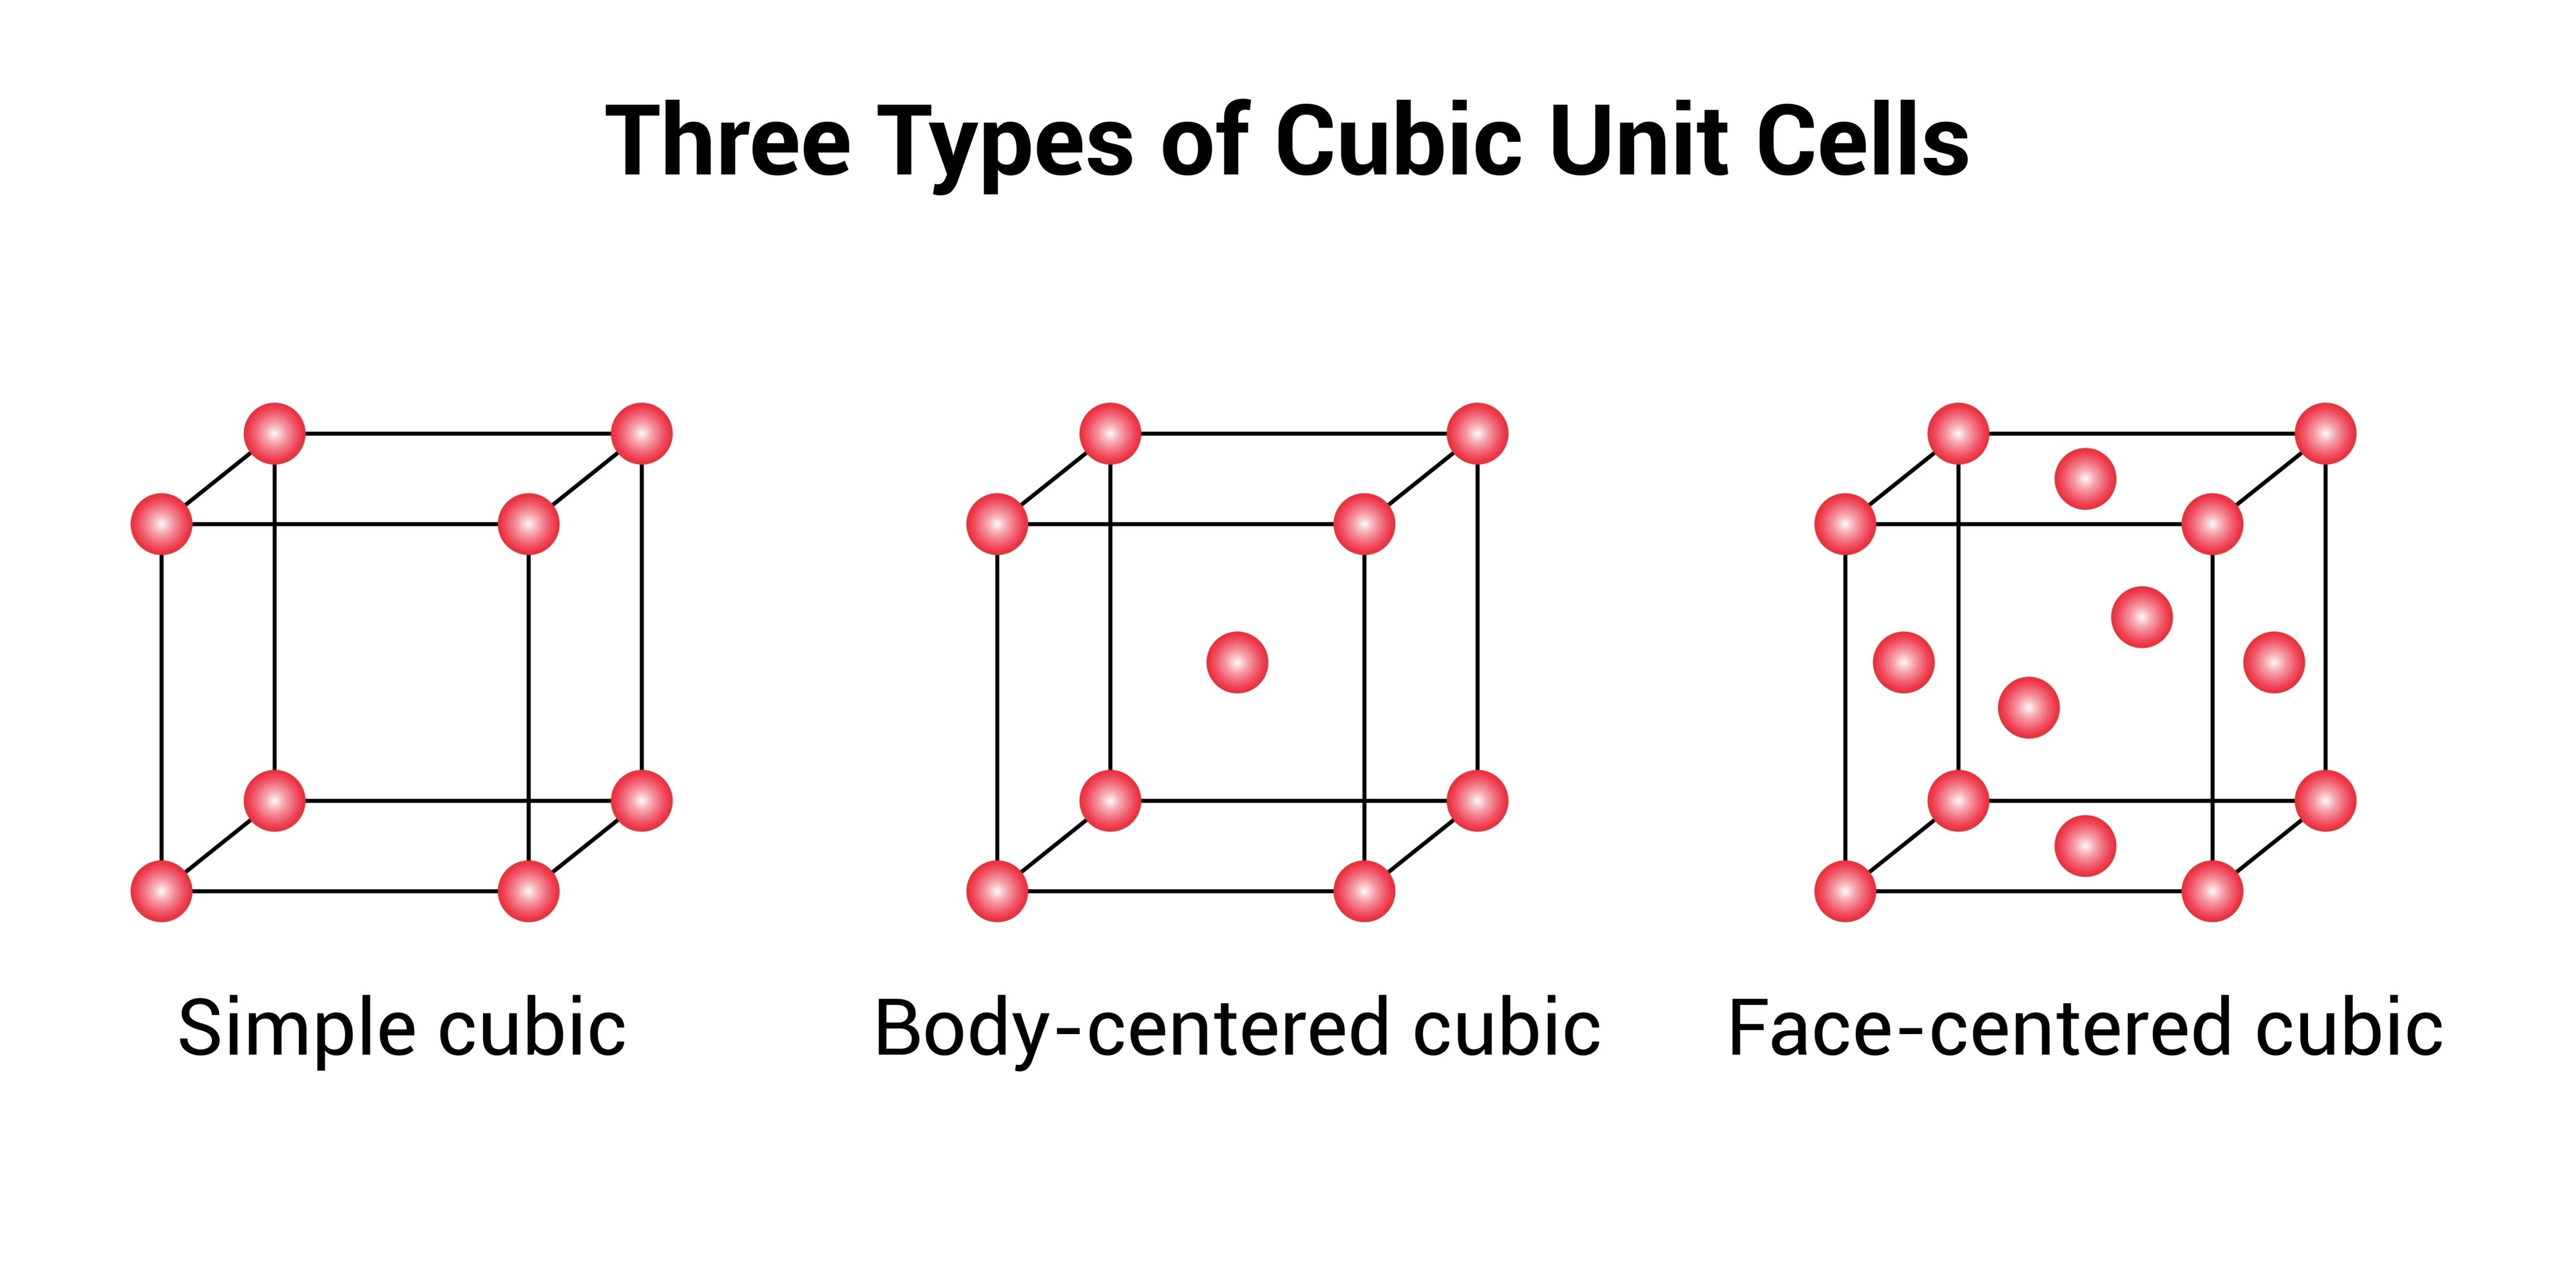

In [83]:
# --- CELL 2: MOLECULE DEFINITIONS ---

def get_catalysis_molecule(formula):
    """
    Returns an ase.Atoms object for specific reaction intermediates.
    """
    formula = formula.upper()
    
    # Standard ASE molecules
    if formula in ['CO', 'CO2', 'H2O', 'NH3', 'N2', 'H2', 'NO']:
        return molecule(formula)
    
    # Custom Definitions (Approximate initial geometries)
    if formula == 'H':
        return Atoms('H')
    elif formula == 'N':
        return Atoms('N', magmom=[3]) # N atom has spin
    elif formula == 'O':
        return Atoms('O', magmom=[2])
    elif formula == 'OH':
        return Atoms('OH', positions=[[0, 0, 0], [0, 0, 0.97]])
    elif formula == 'COOH':
        # Formic acid radical structure
        atoms = Atoms('COOH', positions=[[0,0,0], [1.2,0,0], [0,-1.1,0], [1.5,0.8,0]])
        return atoms
    elif formula == 'NH':
        return Atoms('NH', positions=[[0,0,0], [0,0,1.03]])
    elif formula == 'NH2':
        return Atoms('NHH', positions=[[0,0,0], [0,0.8,0.6], [0,-0.8,0.6]])
    elif formula == 'NNH':
        # N-N-H bent
        return Atoms('NNH', positions=[[0,0,0], [0,0,1.2], [0, 0.9, 1.4]])
    elif formula == 'NHNH':
        # H-N-N-H (Diazene)
        return Atoms('HNNH', positions=[[0.9,0,-0.5], [0,0,0], [0,0,1.25], [-0.9,0,1.75]])
    elif formula == 'NH2NH':
        # Hydrazine radical
        return Atoms('N2H3', positions=[[0,0,0], [0,0,1.45], [0.9,0,-0.4], [-0.9,0,-0.4], [0.9,0,1.8]])
    elif formula == 'NH2NH2':
        return molecule('N2H4') # Hydrazine
    
    # Complex intermediates (simplified geometries for optimization)
    elif formula == 'NH3NH2':
        mol = molecule('N2H4')
        mol.append(Atoms('H', positions=[[0,0,-1.0]])) # Add H loosely
        return mol
        
    print(f"Warning: {formula} not found. Returning empty atoms.")
    return Atoms()

print("Molecule library loaded.")

Molecule library loaded.


In [84]:
# --- BULK & SURFACE STRUCTURE OPTIMIZATION ---
import numpy as np
import matplotlib.pyplot as plt
from ase import Atoms
from ase.build import bulk, fcc111, fcc100, add_adsorbate, molecule, surface
from ase.constraints import FixAtoms
from ase.optimize import BFGS
from ase.visualize import view
from ase.io import read, write
from ase.mep import NEB, DimerControl, MinModeAtoms, MinModeTranslate
from ase.vibrations import Vibrations

# Import the ML Potential
from chgnet.model.dynamics import CHGNetCalculator

# Initialize Calculator (Running on CPU for broad compatibility, use 'cuda' if GPU available)
calc = CHGNetCalculator(use_device='cpu')


## User Input ##
metal_symbol = 'Cu'    # e.g., 'Fe', 'Ru', 'Pt'
guess_lattice = 3.6    # Initial guess in Angstroms
save_name_bulk = "optimized_"+metal_symbol+"_bulk.cif" 

# 1. Build initial bulk
atoms_bulk = bulk(metal_symbol, 'fcc', a=guess_lattice, cubic=True)
atoms_bulk.calc = calc

# 2. Optimize the Unit Cell (Volume and Shape)
from ase.filters import FrechetCellFilter
ucf = FrechetCellFilter(atoms_bulk)
opt = BFGS(ucf)
opt.run(fmax=0.01)

# 3. Save
atoms_bulk.write(save_name_bulk)


# 4. Extract optimized lattice constant
# For FCC, a = distance * sqrt(2) / (number of atoms)^(1/3) approximation
# Or simpler: just read the cell length of the cubic representation
a_opt = atoms_bulk.cell[0][0] * np.sqrt(2) if len(atoms_bulk) == 1 else atoms_bulk.cell[0][0]

print(f"Optimization Complete. Final Lattice Constant a = {a_opt:.3f} A")
print(f"Structure saved to {save_name_bulk}")

write(save_name_bulk, atoms_bulk)
view(atoms_bulk)

CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on cpu
      Step     Time          Energy          fmax
BFGS:    0 08:02:46      -16.328932        0.182274
BFGS:    1 08:02:56      -16.330257        0.158471
BFGS:    2 08:03:06      -16.334101        0.013196
BFGS:    3 08:03:17      -16.334122        0.001799
Optimization Complete. Final Lattice Constant a = 3.617 A
Structure saved to optimized_Cu_bulk.cif


<Popen: returncode: None args: ['/home/gtgambu/anaconda3/bin/python', '-m', ...>

In [85]:
########## SURFACE #################

## User Input
lattice_constant = a_opt # From previous step, or type manually e.g. 3.61
layers =  3              # Standard for catalysis
vacuum_size = 12.0       # Angstroms of empty space
save_name_surface = "clean_"+metal_symbol+"111.cif"
# ==================

# 1. Create the slab (FCC 111 is the most stable surface for many metals)
slab = fcc111(metal_symbol, size=(3, 3, layers), a=lattice_constant, vacuum=vacuum_size) # can also use fcc100 or fcc110 (check import)
slab.calc = calc

# 2. Fix the bottom layers (mimic the bulk material deep below)
# We fix the bottom 2 layers so they act as the "anchor"
fixed_mask = [atom.tag > 2 for atom in slab]
slab.set_constraint(FixAtoms(mask=fixed_mask))

# 3. Optimize the clean surface (Relax top layers)
opt = BFGS(slab)
opt.run(fmax=0.02)

#slab.write(save_name_surface)
#print(f"Clean surface optimized and saved to {save_name_surface}")
write(save_name_surface, slab)
view(slab)

      Step     Time          Energy          fmax
BFGS:    0 08:03:43     -104.781395        0.117562
BFGS:    1 08:04:01     -104.783142        0.112914
BFGS:    2 08:04:20     -104.801109        0.133689
BFGS:    3 08:04:41     -104.803314        0.098549
BFGS:    4 08:05:01     -104.805717        0.078230
BFGS:    5 08:05:23     -104.814682        0.031182
BFGS:    6 08:05:42     -104.816513        0.020278
BFGS:    7 08:06:02     -104.817078        0.008045


<Popen: returncode: None args: ['/home/gtgambu/anaconda3/bin/python', '-m', ...>

In [ ]:
### ADD ADSORBATE AND OPTIMIZE #######
#===============================================================
# Method for addition adsorbates on slabs
import os
from chgnet.model import StructOptimizer

def creat_folder(fname):
    try:
        os.mkdir(fname)
    except FileExistsError:
        print('Folder Exists')
        
def relax_struct_with_CHGNET(a):
    relaxer = StructOptimizer()
    result = relaxer.relax(a,fmax=0.02, verbose=True, relax_cell=False, trajectory="md2_out.traj")
    E0 = a.get_potential_energy()
    return a, E0
    
def solver_with_chgnet(Slab,folderName1):
    creat_folder(folderName1)
    Slab, E0_chgnet = relax_struct_with_CHGNET(Slab)
    write('./'+folderName1+'/POSCAR_CHGNET_bulk', Slab)
    os.popen(" echo 'CHGNET (Bulk)   "+str(E0_chgnet)+" eV' >> ./"+folderName1+"/CHGNET_VASP.dat")
    os.popen("cp md2_out.traj ./"+folderName1+"/")
    print("{0:s}\t{1:5.3f}\t eV CHGNET Bulk".format(folderName1, E0_chgnet))
    return Slab #, E0_chgnet, E0_vasp    
    
def add_new_adsorption(atoms,ads_name,mol_index,sitex):
    xp, yp, zp, phi, theta, psi, siteName = sites_XX[sitex]
    xp, yp = np.dot(np.array([xp,yp]),atoms.cell[:2,:2])
    Adsx = molecule(ads_name)
    Adsx.euler_rotate(theta=theta, phi=phi, psi=psi)
    add_adsorbate(atoms,Adsx,zp,position=(xp,yp),mol_index=mol_index)
    return atoms

## User Input ##
AdsName = 'CO'
AdsIndx = 1
sites_XX = [[0.0, 0.0, 2.0, 90.0, 0.0, 90.0, 'fcc'],[]]
folderName1 = AdsName
#=========================


SlabX=add_new_adsorption(slab.copy(),AdsName,AdsIndx,0)
view(SlabX)
SlabX  = solver_with_chgnet(SlabX,folderName1+sites_XX[0][-1])
view(SlabX)

Folder Exists
CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on cpu


In [81]:
### ADD CO-ADSORBATE AND OPTIMIZE #######
#===============================================================
## User Input ##
# Ads 1:
AdsName1 = 'O'
AdsName2 = 'H'
AdsIndx1 = 0
AdsIndx2 = 0
sites_XX = [[0.445,  0.445, 2.0, 90.0, 0.0, 90.0, 'fcc'],[0.778, 0.445, 2.0, 90.0, 0.0, 90.0, 'fcc']]
folderName1 = "coads_"+AdsName1+"_"+AdsName2+"_"
#=========================

SlabX=add_new_adsorption(slab.copy(),AdsName1,AdsIndx1,0)
#view(SlabX)
SlabX=add_new_adsorption(SlabX.copy(),AdsName2,AdsIndx2,1)
view(SlabX)

SlabX  = solver_with_chgnet(SlabX,folderName1+sites_XX[0][-1])
view(SlabX)

CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on cpu
      Step     Time          Energy          fmax
FIRE:    0 07:50:09     -185.027359        3.166319
FIRE:    1 07:50:21     -185.199020        3.348007
FIRE:    2 07:50:34     -185.567780        3.544381
FIRE:    3 07:50:46     -186.110840        2.861347
FIRE:    4 07:50:58     -186.648590        2.274594
FIRE:    5 07:51:09     -187.112717        2.028616
FIRE:    6 07:51:21     -187.335678        2.140856
FIRE:    7 07:51:32     -187.609528        2.410723
FIRE:    8 07:51:44     -188.071945        1.910788
FIRE:    9 07:51:56     -188.410507        0.858103
FIRE:   10 07:52:08     -188.421753        1.635610
FIRE:   11 07:52:21     -188.449188        1.502024
FIRE:   12 07:52:34     -188.495667        1.224045
FIRE:   13 07:52:47     -188.545135        0.850838
FIRE:   14 07:53:00     -188.584091        0.431551
FIRE:   15 07:53:13     -188.604324        0.515449
FIRE:   16 07:53:27     -188.610825        0.

KeyboardInterrupt: 

In [77]:
view(slab)
write('CONTCAR_textx',slab)

In [ ]:
initial = read("./OHfcc/POSCAR_CHGNET_bulk")
final = read("./coads_O_H_fcc/POSCAR_CHGNET_bulk")

# Setup NEB with 5 images
images = [initial]
for i in range(5):
    img = initial.copy()
    img.calc = calc
    images.append(img)
images.append(final)

neb = NEB(images)
# Interpolate positions
neb.interpolate()

# Optimize NEB
neb_opt = BFGS(neb, trajectory='neb.traj')
neb_opt.run(fmax=0.1) 


In [ ]:
structurex = read("./OHfcc/POSCAR_CHGNET_bulk")
vib = Vibrations(structurex, indices=[-2, -1]) # Only vibrate the adsorbate
vib.run()
vib.summary()